In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
from matplotlib import pyplot as plt
import os
import gc
from load_dataset import get_input_seqs_dataloader
import utils
import lightning.pytorch as pl
import shutil
from IPython.display import clear_output
from scipy import spatial as sp
from Architectures.autoencoder_conv_pl import Autoencoder

c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train, test = get_input_seqs_dataloader('data/AA_orth.joblib',shuffle=False, train_size=0.5, batch_size=64)

In [3]:
random_matrices_orth = joblib.load('data/AA_random_matrices_orth.joblib')

In [5]:
class Item():
    def __init__(self, name, model, correct_prediction, num_elem_tested):
        components = name.split('_')
        self.name = name
        self.model = model
        self.channels, self.latent_dim, self.activation_function, self.optimizer, self.loss_function, self.dropout_rate, self.batch_norm, self.fold = components
        self.correct_prediction = correct_prediction

        #To change 
        self.conv_k = 3
        self.conv_s = 1
        self.conv_p = 1
        self.pool_k = 0
        self.pool_s = 1
        self.num_elem_tested = num_elem_tested

In [ ]:
models = {}
for model in os.listdir("models/Test"):
    if '_ReLU_' not in model and 'LeakyReLU' not in model:
        models[model] = joblib.load("models/Autoencoder1D/"+model)

In [11]:
for aa, vec in random_matrices_orth.items():
    random_matrices_orth[aa] = vec.numpy()

In [11]:
items = []
for name, model in models.items():
    model.cpu()
    o= None
    seqs= []
    for t in test:
        o = model(t[0]).detach().cpu().numpy()
        seqs = t[1] 
        break
    total = utils.batch_correct_reconstructed_amino_acid(seqs, o, random_matrices_orth, 1965)[0]
    items.append(Item(name, model, total, len(seqs)*1965))

In [ ]:
items = joblib.load('models/evaluation.joblib')

In [21]:
bests = sorted(items, key=lambda x: x.correct_prediction)

In [24]:
for p in bests[:10]:
    print(p.name)

[1965, 512, 256, 128, 64]_64_Sigmoid_SGD_MSELoss_0.25_True
[1965, 512, 256, 128, 64]_64_Sigmoid_SGD_MSELoss_0.25_False
[1965, 512, 256, 128, 64]_128_Tanh_AdamW_L1Loss_0_False
[1965, 512, 256, 128, 64]_64_Sigmoid_SGD_MSELoss_0_False
[1965, 512, 256, 128, 64]_64_Sigmoid_SGD_MSELoss_0_True
[1965, 512, 256, 128, 64]_64_Sigmoid_SGD_L1Loss_0.25_True
[1965, 512, 256, 128, 64]_64_Sigmoid_SGD_L1Loss_0.25_False
[1965, 512, 256]_128_Sigmoid_AdamW_MSELoss_0.25_True
[1965, 512, 256, 128]_64_Sigmoid_SGD_L1Loss_0.25_True
[1965, 512, 256]_128_Sigmoid_AdamW_MSELoss_0.25_False


In [14]:
best.correct_prediction

123090

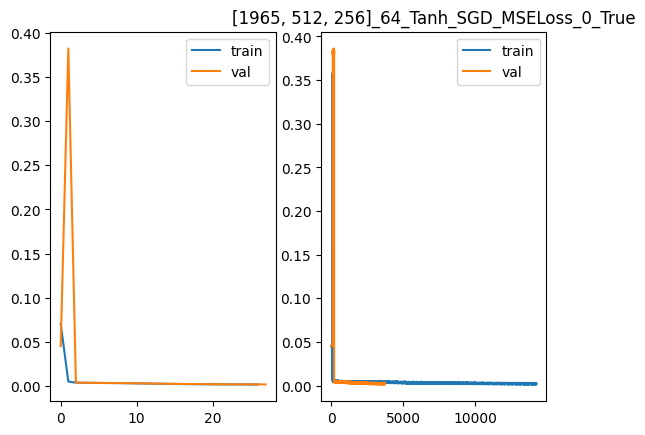

In [15]:
plt.subplot(1,2,1)
plt.plot(range(len(best.model.training_epoch_mean)), best.model.training_epoch_mean, label='train')
plt.plot(range(len(best.model.validation_epoch_mean)), best.model.validation_epoch_mean, label='val')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(best.model.training_step_loss)), best.model.training_step_loss, label='train')
plt.plot(range(len(best.model.validation_step_loss)), best.model.validation_step_loss, label='val')

plt.legend()
plt.title(name)
plt.show()

In [22]:
joblib.dump(best.model, 'best_model.joblib')

['best_model.joblib']

In [9]:
best = joblib.load('models/best_model.joblib')

In [10]:
def get_correct_preds(model, dataloader, random_matrices_orthogonal):
    preds = 0
    for batch in dataloader:
        mats, seqs = batch
        outputs = model(mats).detach().cpu().numpy()
        preds += utils.batch_correct_reconstructed_amino_acid(seqs, outputs, random_matrices_orthogonal, 1965)[0]
    return preds

In [11]:
correct_preds_train = get_correct_preds(best, train, random_matrices_orth)
correct_preds_test = get_correct_preds(best, test, random_matrices_orth)

In [12]:
num_seq_train = sum([len(x[0]) for x in train])
num_seq_test = sum([len(x[0]) for x in test])

In [13]:
# correct number of prediction and accuracy
# 1965 = longuest sequence, num_seq_* = number of sequence
print(correct_preds_train, correct_preds_train/(num_seq_train*1965))
print(correct_preds_test, correct_preds_test/(num_seq_test*1965))

66701267 0.9755896171739125
16668448 0.9751317091520274


In [14]:
best

Autoencoder(
  (loss_func): MSELoss()
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv1d(1965, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Tanh()
      (8): Dropout(p=0, inplace=False)
    )
    (conv_net): Sequential(
      (0): Conv1d(1965, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Tanh()
      (8): Dropout(p=0, inplace=False)
    )
    (fc): Linear(in_features=2816, out_features=1024, bias=True)
  )
  (decoder): Decoder(
 

Create dataset of latent dimension using the encoder from the best model

In [8]:
all_data, _ = get_input_seqs_dataloader('data/AA_orth.joblib',shuffle=False, train_size=1, batch_size=64)

In [29]:
# inputs = data['inputs']
# sequences = data['sequences']
inputs = []
sequences = []
encoder = best.encoder
for batch in all_data:
    mats, seqs = batch
    latent_mats = encoder(mats).detach().cpu()
    inputs.extend(latent_mats)
    sequences.extend(seqs)
joblib.dump({"inputs":torch.stack(inputs), "sequences":sequences}, 'latent_dataset.joblib')

['latent_dataset.joblib']

Evaluate k folds

In [7]:
models = {}
for model in os.listdir("models/K-folds"):
    # if 'Tanh' in model:
        models[model] = joblib.load("models/K-folds/"+model)

In [34]:
s = max([m for m in models.values()],key= lambda x : x.validation_acc[-1])

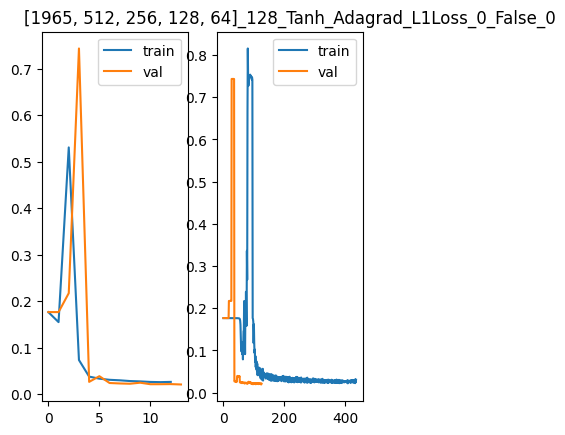

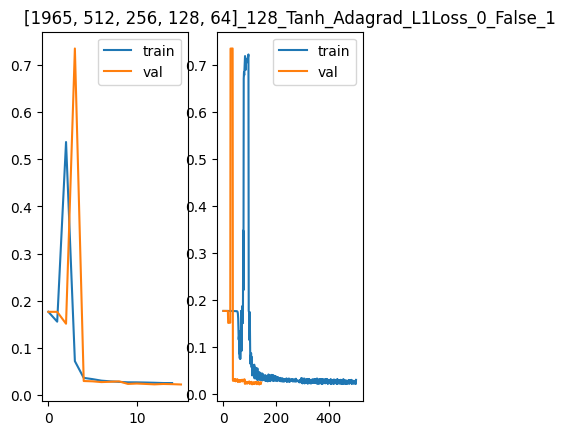

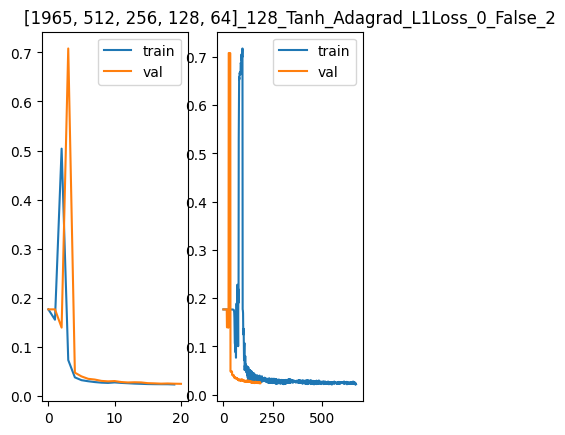

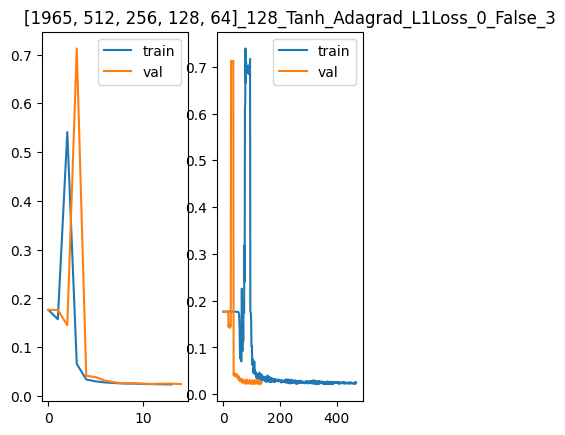

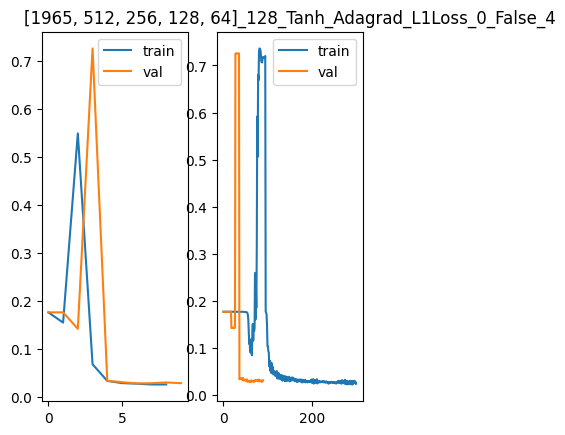

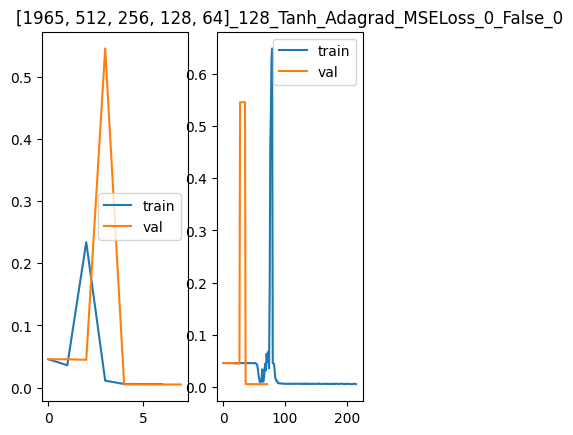

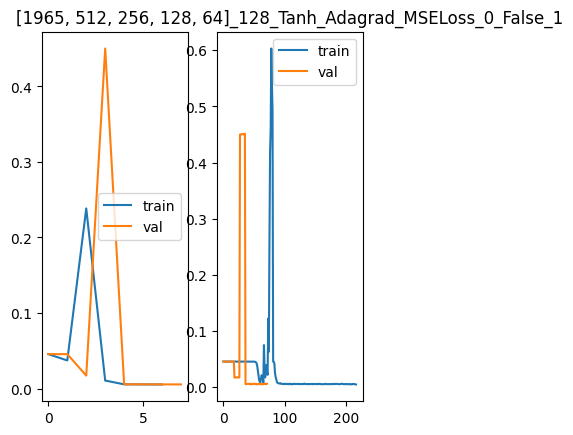

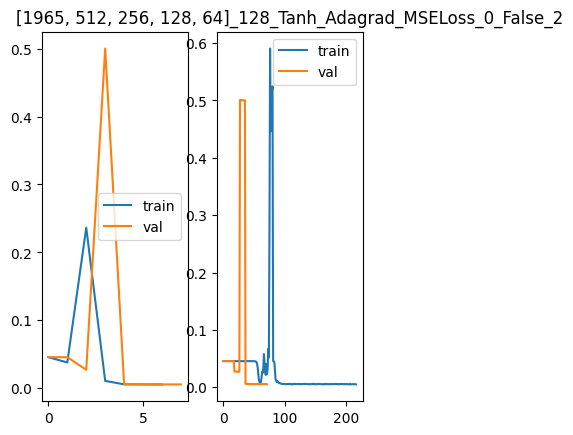

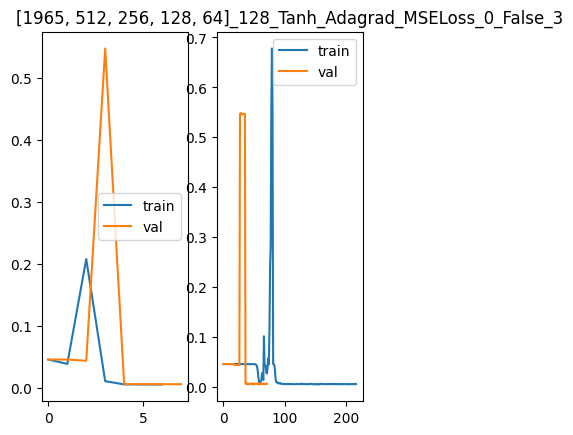

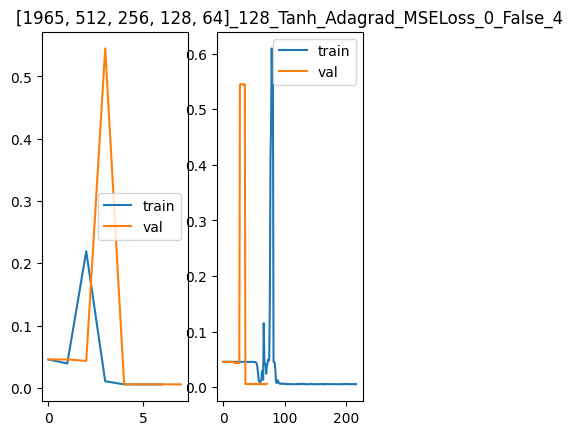

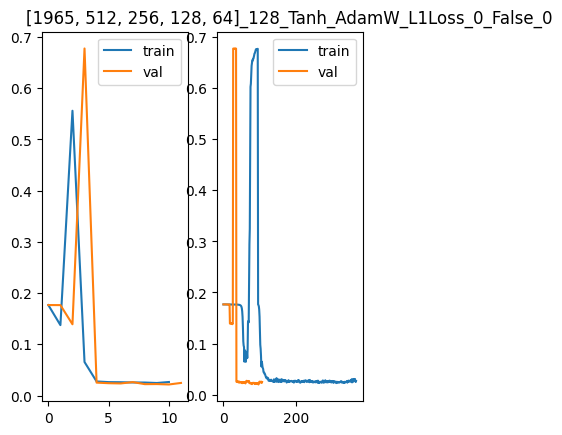

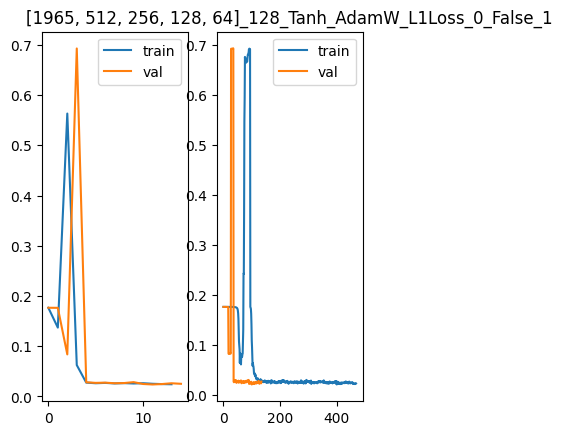

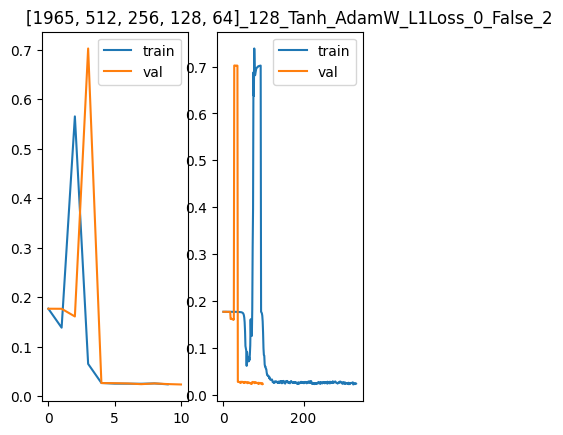

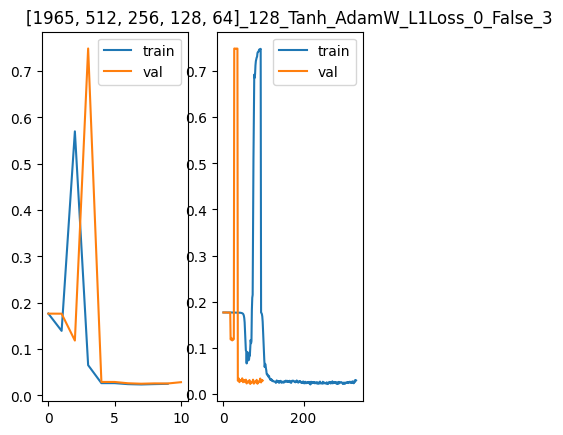

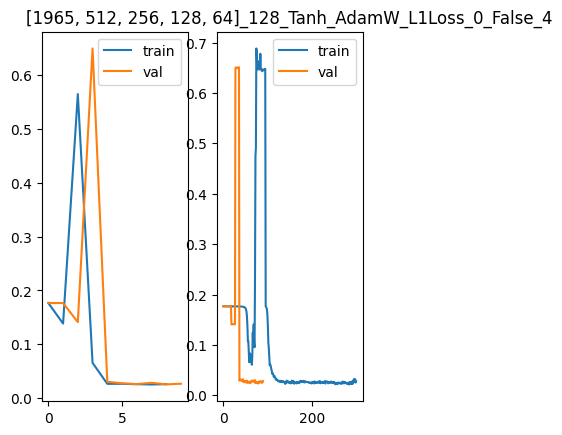

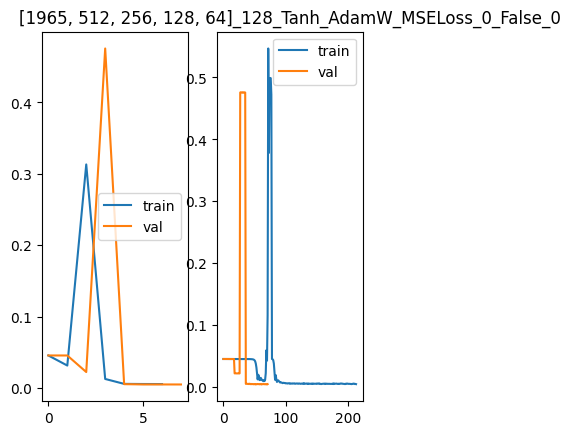

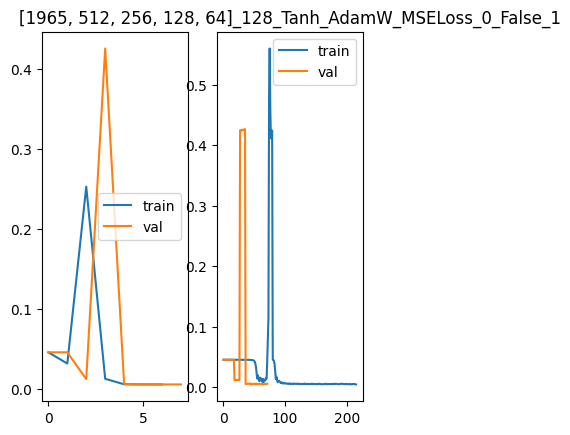

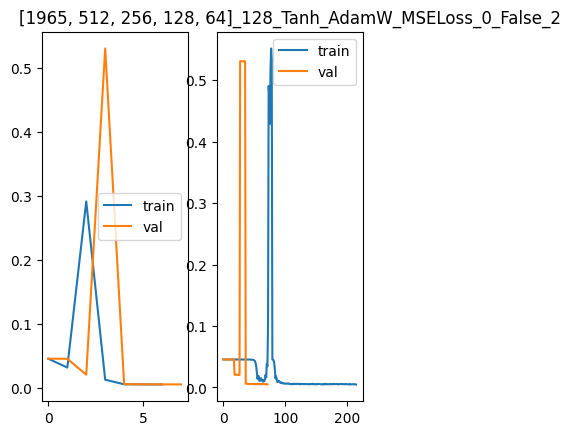

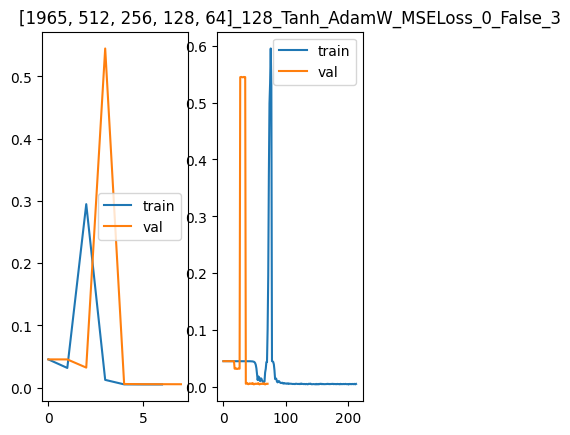

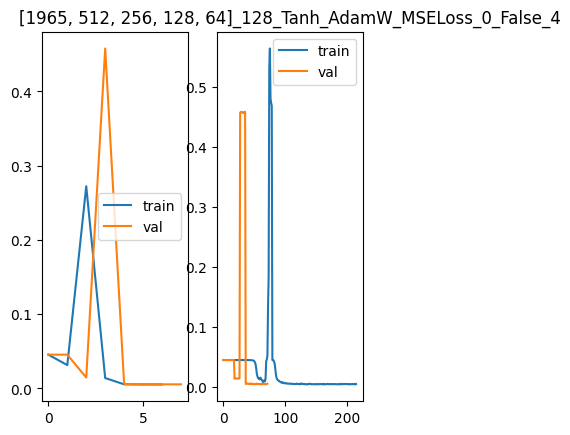

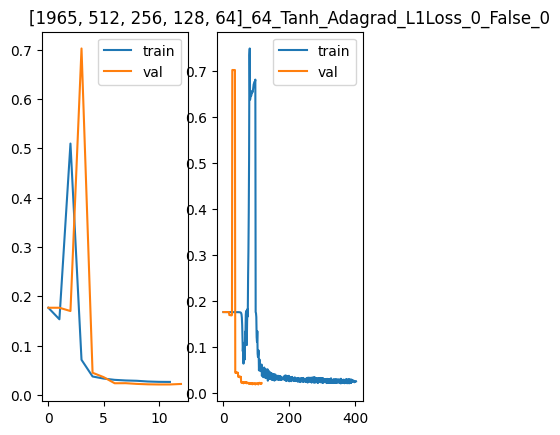

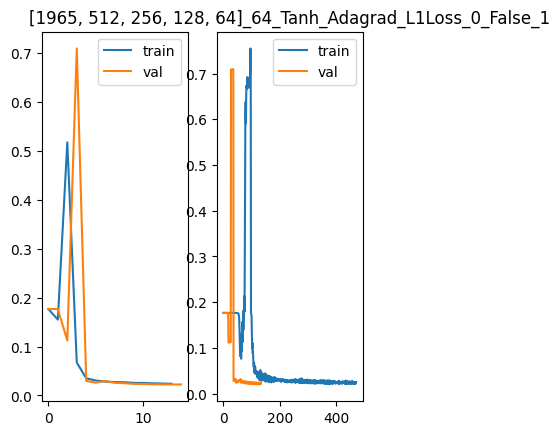

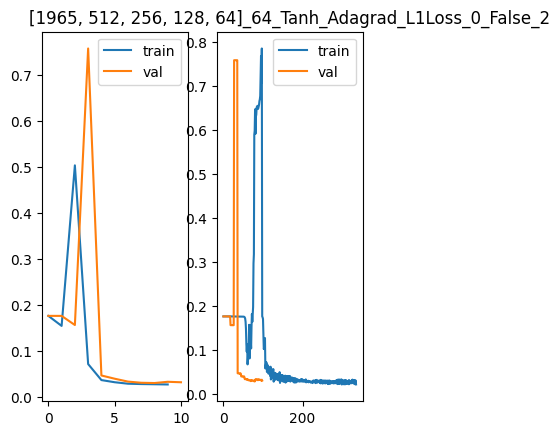

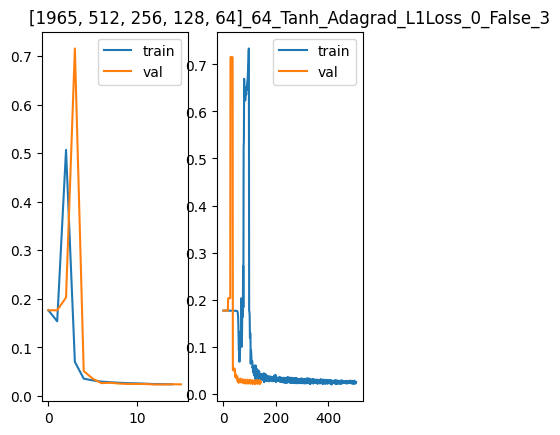

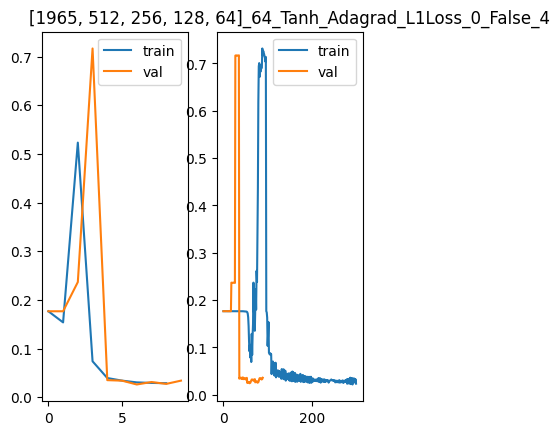

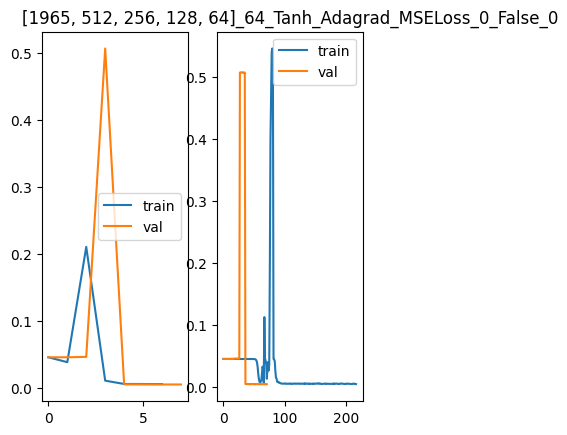

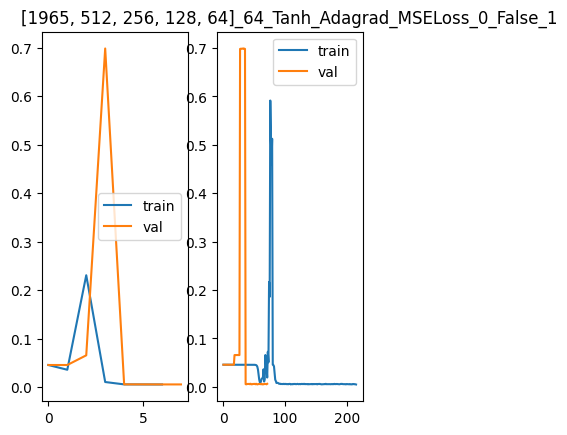

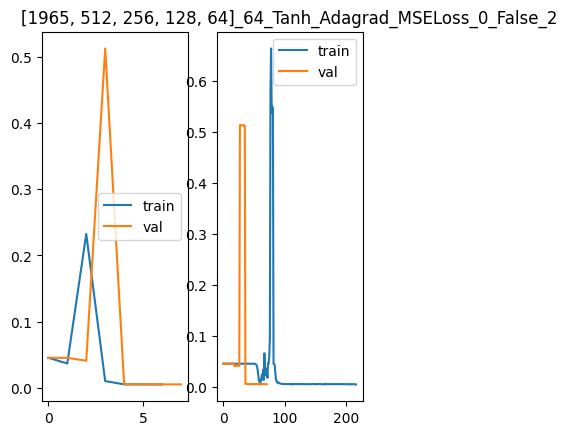

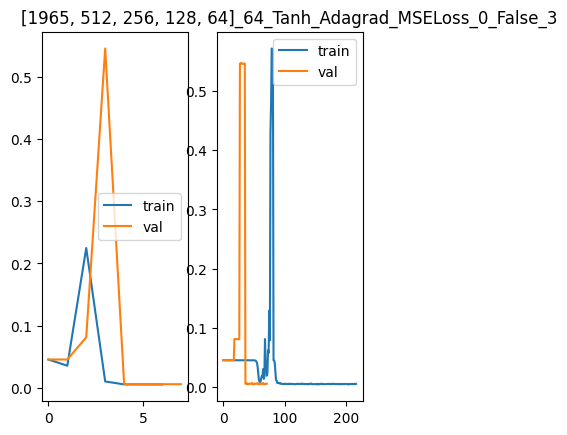

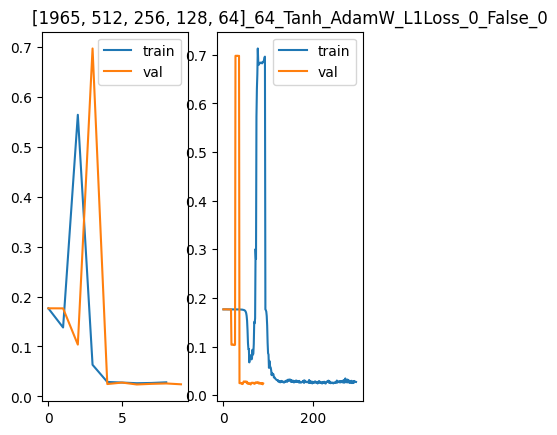

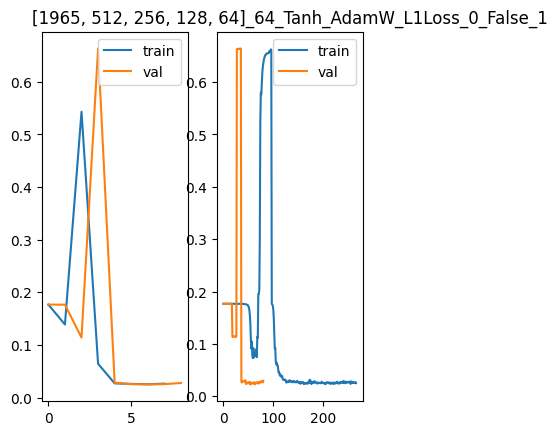

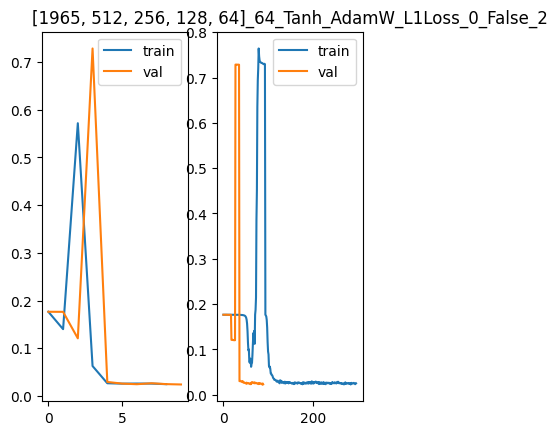

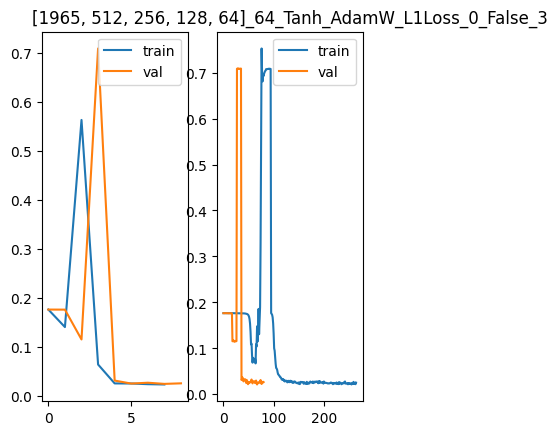

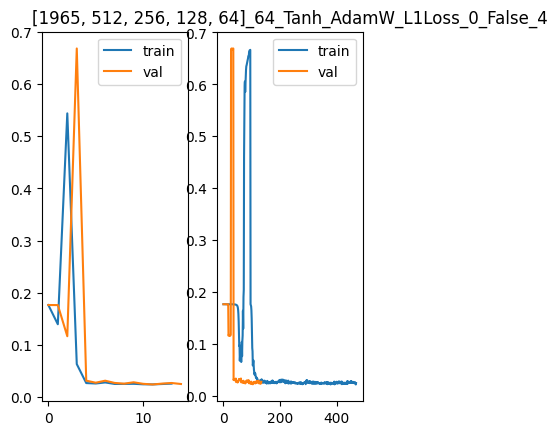

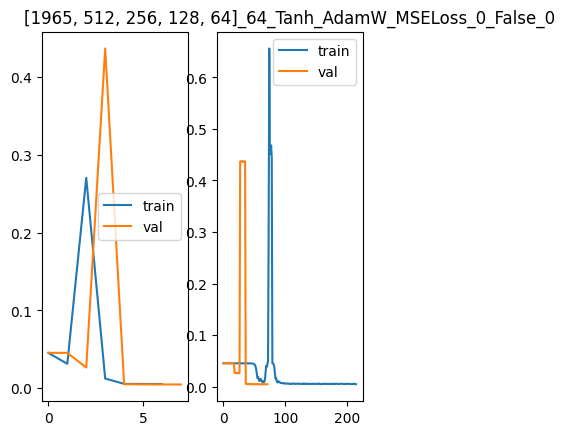

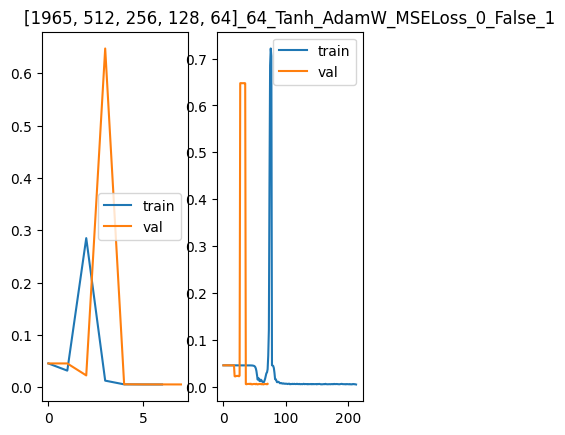

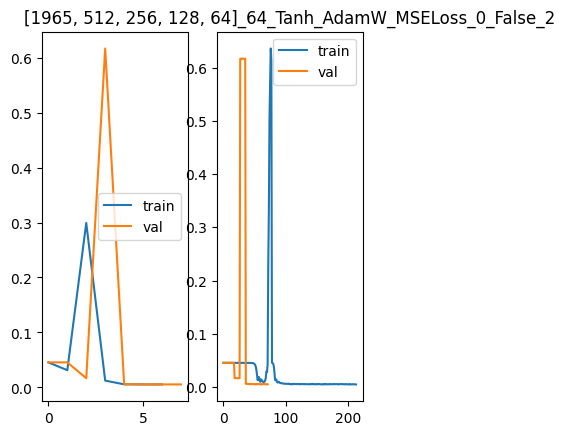

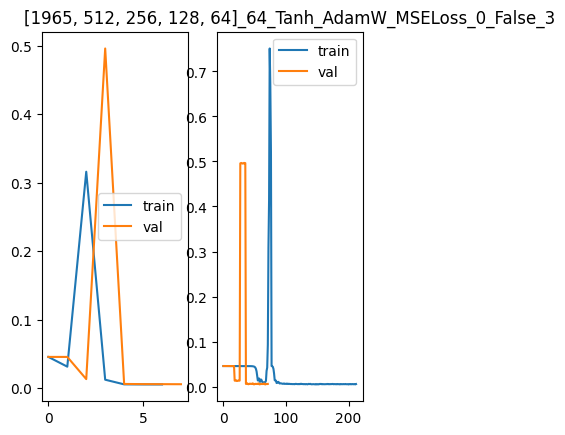

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\Jean-Luc\AppData\Local\Temp\ipykernel_26576\2325178133.py:16 in <module>                │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\Jean-Luc\\AppData\\Local\\Temp\\ipykernel_26576\\2325178133.py'                      │
│                                                                                                  │
│ c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\matplotlib\pyplot.py:446 in show │
│                                                                                                  │
│    443 │   explicitly there.                                                                     │
│    444 │   """                                                                                   │
│    445 │   _warn_if_gui_out_of_main_thread()                                                     │
│ ❱  446 │   return _get_backend_mod().show(*args, **kwargs)                                       │
│    447                                                                                           │
│    448                                                                                           │
│    449 def isinteractive():                                                                      │
│                                                                                                  │
│ c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\matplotlib_inline\backend_inline │
│ .py:90 in show                                                                                   │
│                                                                                                  │
│    87 │   │   close = InlineBackend.instance().close_figures                                     │
│    88 │   try:                                                                                   │
│    89 │   │   for figure_manager in Gcf.get_all_fig_managers():                                  │
│ ❱  90 │   │   │   display(                                                                       │
│    91 │   │   │   │   figure_manager.canvas.figure,                                              │
│    92 │   │   │   │   metadata=_fetch_figure_metadata(figure_manager.canvas.figure)              │
│    93 │   │   │   )                                                                              │
│                                                                                                  │
│ c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\IPython\core\display_functions.p │
│ y:298 in display                                                                                 │
│                                                                                                  │
│   295 │   │   if raw:                                                                            │
│   296 │   │   │   publish_display_data(data=obj, metadata=metadata, **kwargs)                    │
│   297 │   │   else:                                                                              │
│ ❱ 298 │   │   │   format_dict, md_dict = format(obj, include=include, exclude=exclude)           │
│   299 │   │   │   if not format_dict:                                                            │
│   300 │   │   │   │   # nothing to display (e.g. _ipython_display_ took over)                    │
│   301 │   │   │   │   continue                                                                   │
│                                                                                                  │
│ c:\Users\Jean-Luc\.conda\envs\protein-protein\lib\site-packages\IPython\core\formatters.py:179   │
│ in format                                                  

In [24]:
for name, model in models.items():
    plt.subplot(1,2,1)
    plt.plot(range(len(model.training_epoch_mean)), model.training_epoch_mean, label='train')
    plt.plot(range(len(model.validation_epoch_mean)), model.validation_epoch_mean, label='val')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(len(model.training_step_loss)), model.training_step_loss, label='train')
    plt.plot(range(len(model.validation_step_loss)), model.validation_step_loss, label='val')
    # plt.subplot(1,3,3)
    # plt.plot(range(len(model.validation_acc)), model.validation_acc, label='train')
    # # plt.plot(range(len(model.validation_acc)), model.validation_step_loss, label='val')

    plt.legend()
    plt.title(name)
    plt.show()

In [9]:
gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
items = []
for name, model in models.items():
    print(name)
    model.to(gpu)
    o= None
    seqs= []
    total=0
    for t in train:
        o = model(t[0].to(gpu)).detach().cpu().numpy()
        seqs = t[1] 
        total += utils.batch_correct_reconstructed_amino_acid(seqs, o, random_matrices_orth, 1965)[0]
    items.append(Item(name, model, total, len(seqs)*1965))

[1965, 512, 256, 128, 64]_128_Tanh_Adagrad_L1Loss_0_False_0
[1965, 512, 256, 128, 64]_128_Tanh_Adagrad_L1Loss_0_False_1
[1965, 512, 256, 128, 64]_128_Tanh_Adagrad_L1Loss_0_False_2
[1965, 512, 256, 128, 64]_128_Tanh_Adagrad_L1Loss_0_False_3
[1965, 512, 256, 128, 64]_128_Tanh_Adagrad_L1Loss_0_False_4
[1965, 512, 256, 128, 64]_128_Tanh_Adagrad_MSELoss_0_False_0


In [15]:
names = {}
for item in models:
    name = item[:-2]
    if name not in names:
        names[name]=[]
    names[name].append(models[item])

0.9088818635365395


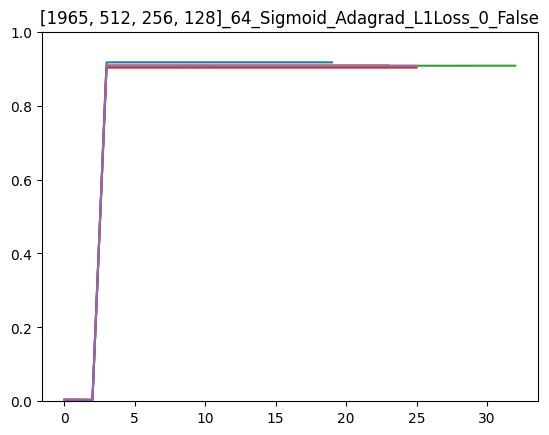

0.9089356259002134


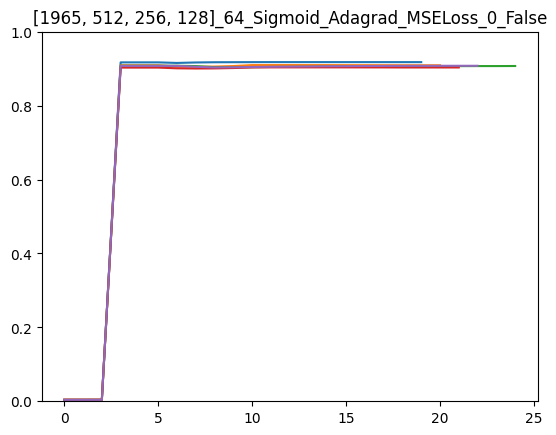

0.9088549886158471


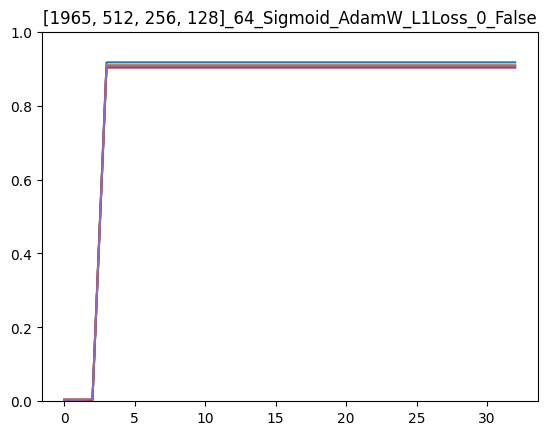

0.909051684915817


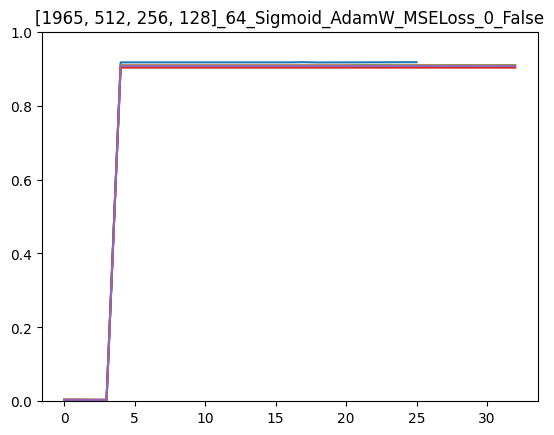

0.9101228711411871


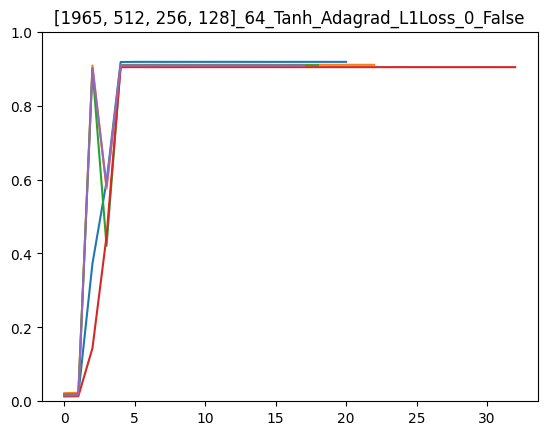

0.9104930300239982


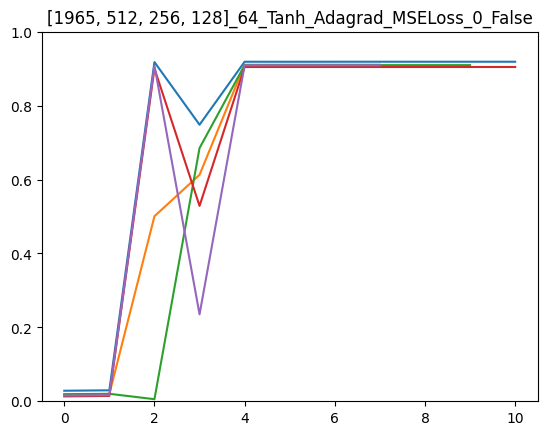

0.9100253558973861


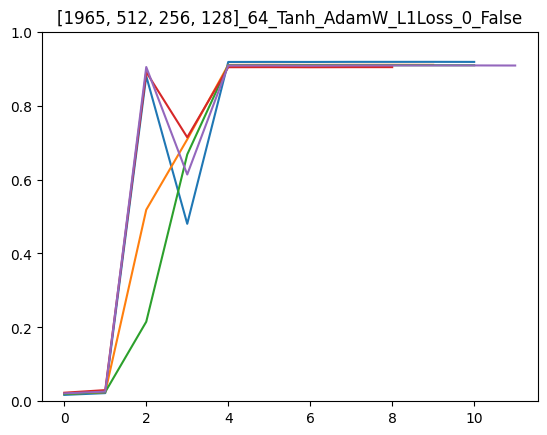

0.9129176691455235


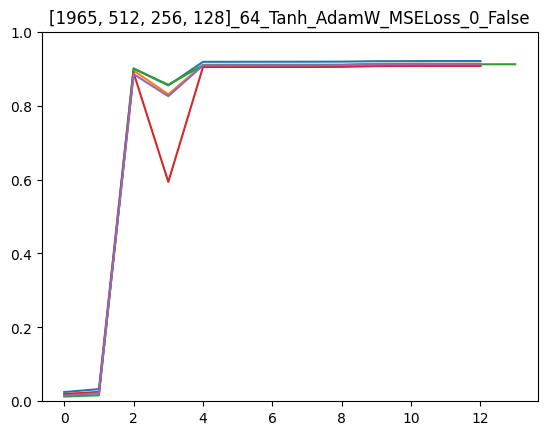

0.9091805131884754


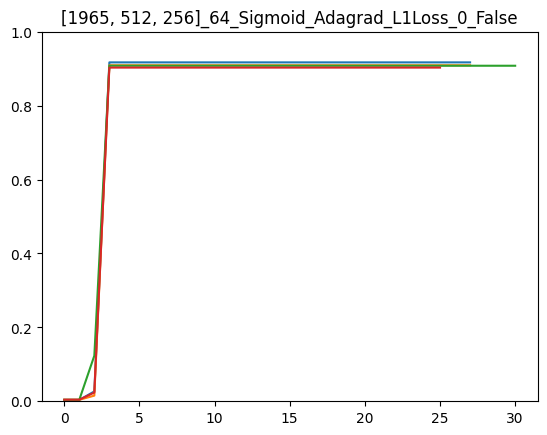

0.9088549886158471


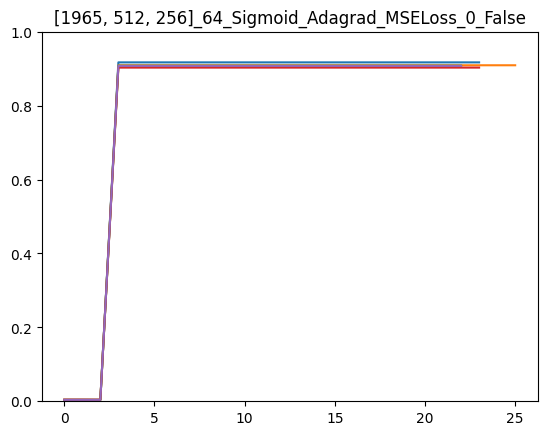

0.9088549886158471


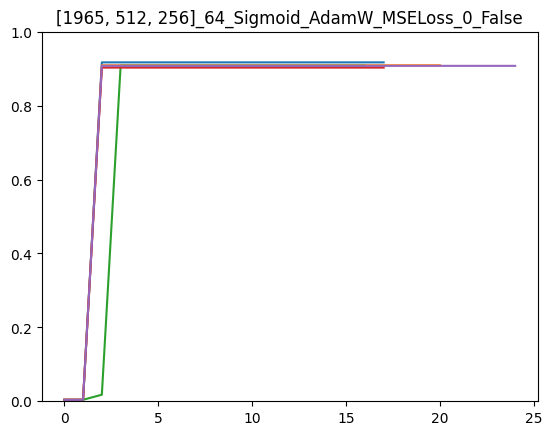

In [38]:
for parent, elems in names.items():
    plt.title(parent)
    last = []
    for i,item in enumerate(elems):
        last.append(item.validation_acc[-1])
        plt.plot(range(len(item.validation_acc)), [acc for acc in item.validation_acc], label=i)
        plt.ylim(0,1)
    print(np.average(last))
    plt.legend
    plt.show()
